# Assignment 1

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets

Matplotlib is building the font cache; this may take a moment.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

Define constants and training parameters:

In [34]:
DATASET_PATH = './data'

BATCH_SIZE = 1024
SHUFFLE_TRAIN = True

NUM_EPOCHS = 50

## Task 1

Train and compare the following models on the CIFAR-10 dataset (available in PyTorch). The models should have slightly optimized parameters to try to maximize their performance.

### Load dataset

In [5]:
train_dataset = datasets.CIFAR10(root=DATASET_PATH, train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.CIFAR10(root=DATASET_PATH, train=False, transform=transforms.ToTensor(), download=True)

100.0%


In [6]:
train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=SHUFFLE_TRAIN
    )

eval_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        # drop_last=True
    )

### MLP

In [7]:
LR = 1e-4

INPUT_DIM = np.prod(train_dataset.data.shape[-3:]) # 32*32*3
OUTPUT_DIM = len(set(train_dataset.targets)) # 10

hidden_dim = int((INPUT_DIM + OUTPUT_DIM) * 2/3) # 2/3 rule
print(f"input dim={INPUT_DIM}, output dim={OUTPUT_DIM}, hidden={hidden_dim}")

input dim=3072, output dim=10, hidden=2054


In [8]:
from mlp import MLP

mlp = MLP(INPUT_DIM, hidden_dim, OUTPUT_DIM)
mlp = mlp.to(device)

In [10]:
from train import train

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=LR)

losses = train(mlp, NUM_EPOCHS, train_loader, device, criterion, optimizer)

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 100 Iteration 49: loss 0.96318. : 100%|██████████| 49/49 [00:04<00:00, 12.19it/s]


In [13]:
from save_utils import save_model_config

save_model_config(mlp)

saved to models/checkpoint_22-23_16-04-2025.pth


### Simple CNN

In [ ]:
# TODO

## Task 2 Analysis

  - Compare the performance of both models: investigate their learning curves (train/eval loss), compare their test accuracy, and compute their confusion matrix
  - Visualize some images, along with the predictions from your models. In what images do your models fail more often? Why do you think so?

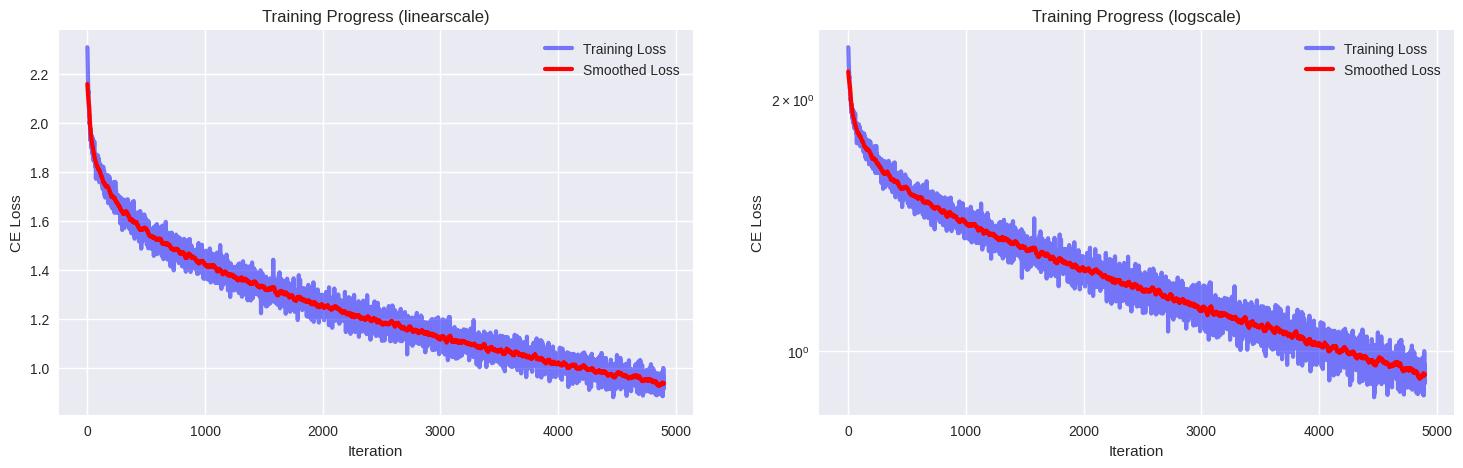

In [14]:
from visualize import plot_learning_curve

plot_learning_curve(losses)

In [22]:
from evaluate import evaluate
from torchmetrics.classification import MulticlassConfusionMatrix

confmat = MulticlassConfusionMatrix(num_classes=OUTPUT_DIM).to(device)
metrics = evaluate(mlp, eval_loader, device, confmat)

print(metrics)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 12.70it/s]

{'accuracy': 55.44, 'confusion_matrix': MulticlassConfusionMatrix()}


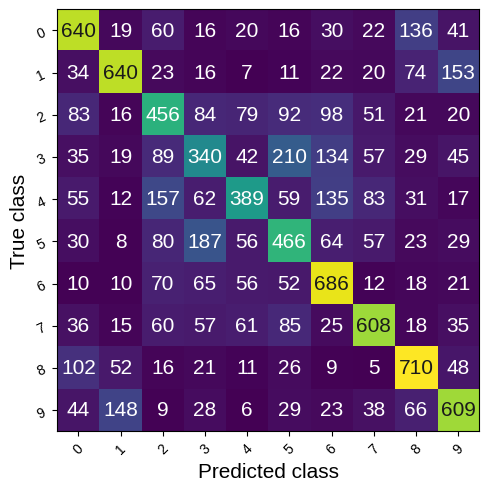

In [23]:
fig_, ax_ = metrics['confusion_matrix'].plot()

In [27]:
for class_count in range(OUTPUT_DIM):
    print(f"occurencies of label={class_count}: {eval_loader.dataset.targets.count(class_count)}")

occurencies of label=0: 1000
occurencies of label=1: 1000
occurencies of label=2: 1000
occurencies of label=3: 1000
occurencies of label=4: 1000
occurencies of label=5: 1000
occurencies of label=6: 1000
occurencies of label=7: 1000
occurencies of label=8: 1000
occurencies of label=9: 1000


The worst predictions are for class labels 3 and 4

In [ ]:
# TODO plot images

## Task 3 Mitigate Overfitting

  - Train both models with and without DropOut. Compare the results: training and validation loss, accuracy, ...
  - Implement and use **your own** custom learning rate warmup and learning rate scheduler criterion to avoid overfitting.<br>
    It is not allowed to use PyTorch's schedulers, but you should code your own.<br>
    Train **one model** using it and show whether you can mitigate overfitting.

In [35]:
mlp_with_dropout = MLP(INPUT_DIM, hidden_dim, OUTPUT_DIM, True)
mlp_with_dropout = mlp_with_dropout.to(device)

mlp_with_dropout_criterion = nn.CrossEntropyLoss()
mlp_with_dropout_optimizer = torch.optim.Adam(mlp_with_dropout.parameters(), lr=LR)

mlp_with_dropout_losses = train(mlp_with_dropout, NUM_EPOCHS, train_loader,
                                device, mlp_with_dropout_criterion, mlp_with_dropout_optimizer)

Epoch 50 Iteration 49: loss 1.03289. : 100%|██████████| 49/49 [00:04<00:00, 12.03it/s]


In [36]:
confmat_with_dropout = MulticlassConfusionMatrix(num_classes=OUTPUT_DIM).to(device)
metrics_with_dropout = evaluate(mlp_with_dropout, eval_loader, device, confmat_with_dropout)

print(metrics_with_dropout)

100%|██████████| 10/10 [00:00<00:00, 12.48it/s]

{'accuracy': 54.48, 'confusion_matrix': MulticlassConfusionMatrix()}


In [37]:
mlp_without_dropout = MLP(INPUT_DIM, hidden_dim, OUTPUT_DIM, True)
mlp_without_dropout = mlp_without_dropout.to(device)

mlp_without_dropout_criterion = nn.CrossEntropyLoss()
mlp_without_dropout_optimizer = torch.optim.Adam(mlp_without_dropout.parameters(), lr=LR)

mlp_without_dropout_losses = train(mlp_without_dropout, NUM_EPOCHS, train_loader,
                                device, mlp_without_dropout_criterion, mlp_without_dropout_optimizer)

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 50 Iteration 49: loss 0.94582. : 100%|██████████| 49/49 [00:04<00:00, 11.92it/s]


In [38]:
confmat_without_dropout = MulticlassConfusionMatrix(num_classes=OUTPUT_DIM).to(device)
metrics_without_dropout = evaluate(mlp_without_dropout, eval_loader, device, confmat_without_dropout)

print(metrics_without_dropout)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 12.40it/s]

{'accuracy': 54.16, 'confusion_matrix': MulticlassConfusionMatrix()}


In [ ]:
# TODO own custom learning warmup